### Ticket 1: Data Preparation & Cleaning

In [170]:
# Load libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import re

In [171]:
# Import dataset

path = r"C:\Users\ntomb\Desktop\Scrappy-20250215T170650Z-001\Scrappy\Scraped_files\Delli_products.csv"
delli_df = pd.read_csv(path)

# Make a copy

df = delli_df.copy()

In [172]:
# Determine the first 5 itm on the dataframe

df.head()

,name,price,url
0,DELLI 'Start Here' Box,£32.00,/products/delli-start-here-box
1,'Nice And Spice' Box,£32.00,/products/the-nice-and-spice-box
2,Irn Bru & Whisky Hot Sauce,£6.95,/products/irn-bru-whisky-hot-sauce
3,"'Sugar, Spice & All Things Nice' Box",£32.00,/products/sugar-spice-all-things-nice-box
4,Crispy Chicken Skin Sambal,£9.50,/products/mirin-crispy-chicken-skin-sambal


In [173]:
# Determine the total number of rows and colums

df.shape

(610, 3)

In [174]:
# Clean trailing whitespace and qoutes

df['name'] = df['name'].str.replace('[\'"]', '', regex=True).str.strip()
df['name'].head()

0                  DELLI Start Here Box
1                    Nice And Spice Box
2            Irn Bru & Whisky Hot Sauce
3    Sugar, Spice & All Things Nice Box
4            Crispy Chicken Skin Sambal
Name: name, dtype: object

In [175]:
# Remove £ on price and trailing whitespace

df['price'] = df['price'].replace('£', '', regex=True).str.strip()
df['price'].head()

0    32.00
1    32.00
2     6.95
3    32.00
4     9.50
Name: price, dtype: object

In [176]:
#  Determine Data type

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610 entries, 0 to 609
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    610 non-null    object
 1   price   443 non-null    object
 2   url     610 non-null    object
dtypes: object(3)
memory usage: 14.4+ KB


In [177]:
# Convert price to nemeric for data analysis

df['price'] = pd.to_numeric(df['price'], errors='coerce')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610 entries, 0 to 609
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   name    610 non-null    object 
 1   price   443 non-null    float64
 2   url     610 non-null    object 
dtypes: float64(1), object(2)
memory usage: 14.4+ KB


In [178]:
# Determine if there NaN values
df.isna().sum()

name       0
price    167
url        0
dtype: int64

In [179]:
# Fill NaN values with 0

df['price'] =  df['price'].fillna(0)

# confirm the results
df.isna().sum()


name     0
price    0
url      0
dtype: int64

In [180]:
# Check for duplicate column (There are 3 columns)
# The check is deemed not necessary for columns are are easily identifiable

df.T.duplicated().any()

False

In [181]:
# Check for duplicate rows

df.duplicated().any()

True

In [182]:
# Find duplicate rows

df.duplicated().sum()

59

In [183]:
# Show duplicate rows under name

df.loc[df.duplicated(keep=False), ['name','price']]

,name,price
0,DELLI Start Here Box,32.00
1,Nice And Spice Box,32.00
2,Irn Bru & Whisky Hot Sauce,6.95
4,Crispy Chicken Skin Sambal,9.50
6,Chilli Vinegar Dressing,7.80
...,...,...
570,When The Fish Came To Shore (Greek Cookbook) *...,25.00
573,Uno Mag Tomatoes (Cookbook-Magazine),18.00
592,Uno Mag Tomatoes (Cookbook-Magazine),18.00
595,When The Fish Came To Shore (Greek Cookbook) *...,25.00


In [184]:

# The price is deemed normal to the same

def remove_duplicated_rows(df):
    duplicated_rows = df.drop_duplicates(subset=['name'], keep='first')
    return duplicated_rows

df = remove_duplicated_rows(df)

# Check duplicated rows if still exist

df.duplicated().any()

False

### Ticket 2: Product Performance Analysis

####  1. Statistics & Analysis:

In [185]:
df.head(2)

,name,price,url
0,DELLI Start Here Box,32.0,/products/delli-start-here-box
1,Nice And Spice Box,32.0,/products/the-nice-and-spice-box


In [186]:
# convert price from USD to ZAR usign API 

In [187]:
df.describe().round(2)

,price
count,548.00
mean,8.84
std,10.06
min,0.00
25%,0.00
50%,6.20
75%,10.00
max,60.00


In [188]:
# Determine the most expensive product

Expensive_product = df.loc[df['price'].idxmax(), ['name','price']]
Expensive_product

name     Sober Curious Warmers Box
price                         60.0
Name: 472, dtype: object

In [189]:
# Determine the least expensive

In [190]:
# First filter for prices above 0, then find the minimum price thereafter

filtered_df = df[df['price'] > 0]  

cheap_product = filtered_df.loc[filtered_df['price'].idxmin(), ['name', 'price']]
cheap_product

name     Snacking Pickles
price                 1.6
Name: 8, dtype: object

In [191]:
df.shape

(548, 3)

In [192]:
# Determine category on price while excluding 0 values

filtered_df = df[df['price'] > 0]

median_price = filtered_df['price'].median()
upper_quartile = filtered_df['price'].quantile(0.75)

def categorize_price(price):
    if price <= 0:  
        return 'Invalid'
    elif price < median_price:
        return 'Ordinary'
    elif price < upper_quartile:
        return 'High'
    else:
        return 'Exclusive'

df['category'] = df['price'].apply(categorize_price)


In [193]:
# Determine Revenue in Exclusive category

df['Exclusive_price'] = df.loc[df['category'] == 'Exclusive', 'price']
df['Exclusive_price'] =  df['Exclusive_price'].fillna(0)

In [194]:
# Determine Revenue in High Category

df['High_price'] = df.loc[df['category'] == 'High', 'price']
df['High_price'] = df['High_price'].fillna(0)

In [195]:
# Deternine Revenue in Ordinary category
df['Ordinary_price'] = df.loc[df['category'] == 'Ordinary', 'price']
df['Ordinary_price'] = df['Ordinary_price'].fillna(0)

In [196]:
# Determine the total revene per category and number product items

Category_analysis = df.groupby('category').agg(
    total_items=('price', 'count'),
    total_revenue=('price', 'sum')
)
Category_analysis

,total_items,total_revenue
category,,
Exclusive,100,2697.34
High,107,1075.99
Invalid,150,0.00
Ordinary,191,1073.34


In [197]:
# Determine Total revenue

Total_revenue = df['price'].sum()


In [198]:
df.shape

(548, 7)

#### 2. Visualizations:

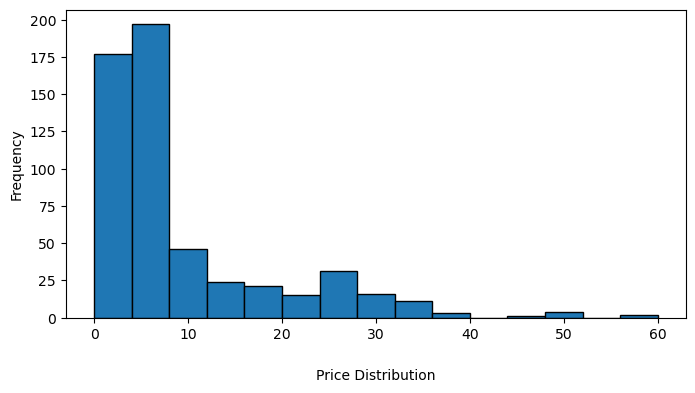

In [199]:
# Determine price distribution

price_counts = df['price']

plt.figure(figsize=(8,4))
price_counts.plot(kind='hist',bins=15,edgecolor='black')
plt.xlabel('Price Distribution')
plt.xlabel('Price Distribution', labelpad=20)
plt.show()


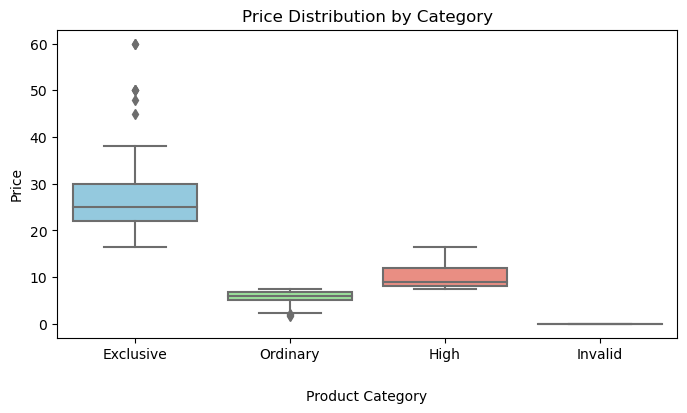

In [200]:
# Determine price distribution by category

plt.figure(figsize=(8,4))

sns.boxplot(x='category', y='price', data=df, palette=['skyblue','lightgreen','salmon'])
plt.title('Price Distribution by Category')
plt.xlabel('Product Category', labelpad=20)
plt.ylabel('Price')
plt.show()

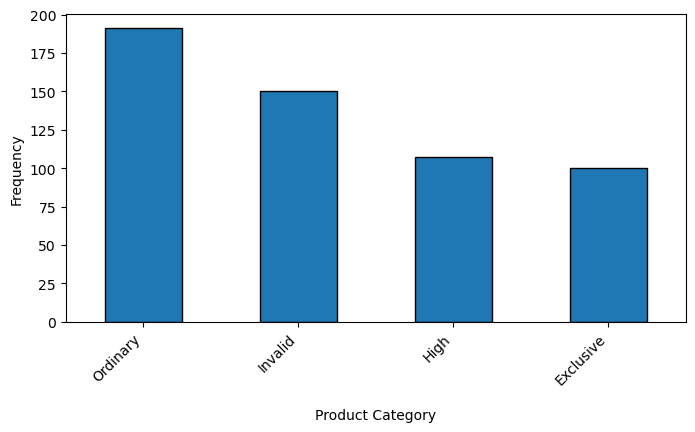

In [201]:
# Category analysis by class

category = df['category'].value_counts()

plt.figure(figsize=(8,4))
category.plot(kind='bar',edgecolor='black')
plt.ylabel('Frequency')
plt.xlabel('Product Category')
plt.xlabel('Product Category', labelpad=15)
plt.xticks(rotation=45,ha='right')
plt.show()

In [202]:
# Revenue analysis by category

revenue_category = df.groupby('category')['price'].sum().reset_index()
revenue_category 

,category,price
0,Exclusive,2697.34
1,High,1075.99
2,Invalid,0.00
3,Ordinary,1073.34


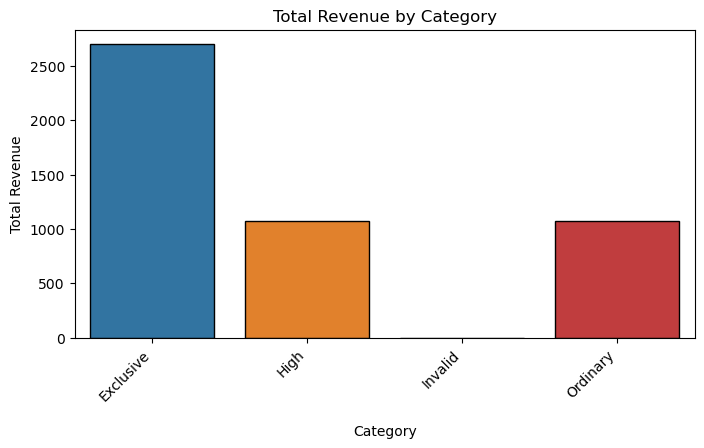

In [203]:
# Category analysis by Revenue

plt.figure(figsize=(8,4))
sns.barplot(data=revenue_category, x='category', y='price',edgecolor='black')
plt.title('Total Revenue by Category')
plt.xlabel('Category')
plt.xlabel('Category', labelpad=15)
plt.xticks(rotation=45,ha='right')
plt.ylabel('Total Revenue')
plt.show()

In [204]:
df.head()

,name,price,url,category,Exclusive_price,High_price,Ordinary_price
0,DELLI Start Here Box,32.00,/products/delli-start-here-box,Exclusive,32.0,0.0,0.00
1,Nice And Spice Box,32.00,/products/the-nice-and-spice-box,Exclusive,32.0,0.0,0.00
2,Irn Bru & Whisky Hot Sauce,6.95,/products/irn-bru-whisky-hot-sauce,Ordinary,0.0,0.0,6.95
3,"Sugar, Spice & All Things Nice Box",32.00,/products/sugar-spice-all-things-nice-box,Exclusive,32.0,0.0,0.00
4,Crispy Chicken Skin Sambal,9.50,/products/mirin-crispy-chicken-skin-sambal,High,0.0,9.5,0.00


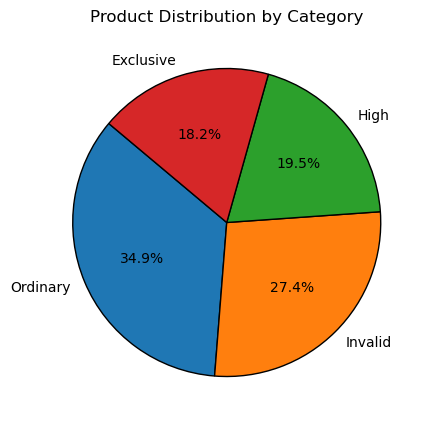

In [216]:
# Determine category disribution by percentage
category_counts = df['category'].value_counts()

plt.figure(figsize=(6,5))
plt.pie(x=category_counts.values, labels=category_counts.index, 
        autopct='%1.1f%%', startangle=140,wedgeprops={'edgecolor': 'black'})
plt.title('Product Distribution by Category')
plt.show()

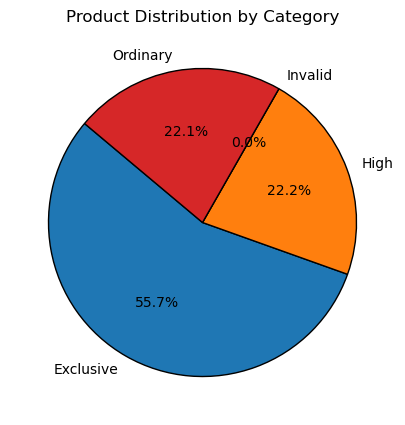

In [221]:
# Determine category revenue by percentage

revenue_category = df.groupby('category')['price'].sum().reset_index()

plt.figure(figsize=(6,5))
plt.pie(x=revenue_category['price'], labels=revenue_category['category'],
        autopct='%1.1f%%', startangle=140,wedgeprops={'edgecolor': 'black'})
plt.title('Product Distribution by Category')
        
plt.show()